### Import

In [2]:
# # prompt: mount drive

# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#%cd '/content/drive/MyDrive/Colab_Notebooks/ML/image_seg/'

/content/drive/MyDrive/Colab_Notebooks/ML/image_seg


In [1]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import ipywidgets #externally create label
from PIL import Image
import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset
from torchsummary import summary
import torchvision.transforms as transforms

from torchvision.transforms import v2



In [2]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)

print(f"Using {device} device")

Using cuda device


## Data extraction and shuffling

In [3]:
image_size = 150 #scaling a constant image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
label_idx = {
    'glioma': 0,
    'meningioma': 1,
    'notumor': 2,
    'pituitary': 3
}

In [18]:
#"projects\proj2\data\Training"

In [5]:
X = []
y = []

for i in labels:
    folderPath = os.path.join('data\Training', i) #each iteration in training folder
    for j in os.listdir(folderPath):                                               # read the images in the dir
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img,(image_size, image_size))                                        # resale the image
            X.append(img)
            y.append(label_idx[i])                                                          # the ith label will the y

for i in labels:
    folderPath = os.path.join('data\Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img,(image_size, image_size))
            X.append(img)
            y.append(label_idx[i])
                                                                # all test and train data are put into X and y train, then they will be shuffeled


X = np.array(X, dtype = np.float32)
y = np.array(y, dtype = np.float32)



In [6]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

## Train Test Split

In [7]:
X.shape, y.shape

(torch.Size([7023, 150, 150, 3]), torch.Size([7023]))

In [8]:
# split whole dataset into training and test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.15, random_state = 107, shuffle = True)

# split training into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.15, random_state = 42, shuffle = True)

In [ ]:
# prompt: plot a histogram plot of y_test, y_val, y_train separately



# # Plot histogram for y_test
# plt.hist(y_test, bins=4)
# plt.title("Histogram of y_test")
# plt.show()

# # Plot histogram for y_val
# plt.hist(y_val, bins=4)
# plt.title("Histogram of y_val")
# plt.show()

# # Plot histogram for y_train
# plt.hist(y_train, bins=4)
# plt.title("Histogram of y_train")
# plt.show()


# Model Architecture

In [24]:
class BrainSegCNN(nn.Module):
    def __init__(self):
        super(BrainSegCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 18 * 18, 512)  # Update dimensions after pooling
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x), dim = 1)
        return x

# Augmentation

In [9]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        label = torch.as_tensor(label, dtype=torch.long)
        image = torch.permute(image, (2, 0, 1))
        if self.transform:

            image = self.transform(image)

        return image, label

# Define data augmentations
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(150)
])



# Prepare datasets with augmentations
train_dataset = AugmentedDataset(X_train, y_train, transform=transform)
val_dataset = AugmentedDataset(X_val, y_val)  # No augmentations for validation
test_dataset = AugmentedDataset(X_test, y_test) #, transform=transforms.ToTensor())  # No augmentations for test



# Train loop

In [10]:
# Training function
def train(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch = 0

        for image, label in train_loader:
            image = image.to(device)  # Move image to device and convert to float
            label = label.to(device)
            outputs = model(image)

            loss = criterion(outputs, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #_, predicted = torch.max(outputs.data, 1)
            #total += label.size(0)
            #correct += (predicted == label).sum().item()
            # print(f"Batch no. : {batch}")
            # batch = batch + 1

            outputs_label = torch.argmax(outputs , dim = 1)
            correct += torch.sum(outputs_label == label)
            total += label.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)
                outputs = model(image)
                #output_label = torch.argmax(outputs, dim = 1)
                loss = criterion(outputs, label)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# parameters arguments

In [35]:

# initialize model
model = BrainSegCNN()
model.to(device)

# loss funtion
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr  = 1e-6)

# epoch
epochs  = 50

#batch size
batch_size = 100

# threads
num_workers = 2

In [40]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers) #, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)#, pin_memory=True)

# train_loader = train_loader.to(device)
# val_loader = val_loader.to(device)

In [41]:
device = next(model.parameters()).device
print(f"Model is on {device}")

Model is on cuda:0


# Model Training

In [42]:
# Train the model
# train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(
#     model, criterion, optimizer, train_loader, val_loader, epochs)

Epoch [1/50], Train Loss: 1.3546, Train Acc: 0.2866, Val Loss: 1.3268, Val Acc: 0.4431
Epoch [2/50], Train Loss: 1.3367, Train Acc: 0.3154, Val Loss: 1.2977, Val Acc: 0.5056
Epoch [3/50], Train Loss: 1.3227, Train Acc: 0.3588, Val Loss: 1.2762, Val Acc: 0.5246
Epoch [4/50], Train Loss: 1.3127, Train Acc: 0.3881, Val Loss: 1.2708, Val Acc: 0.5212
Epoch [5/50], Train Loss: 1.3076, Train Acc: 0.3994, Val Loss: 1.2466, Val Acc: 0.5513
Epoch [6/50], Train Loss: 1.3013, Train Acc: 0.4183, Val Loss: 1.2399, Val Acc: 0.5614
Epoch [7/50], Train Loss: 1.2990, Train Acc: 0.4118, Val Loss: 1.2180, Val Acc: 0.5614
Epoch [8/50], Train Loss: 1.2917, Train Acc: 0.4311, Val Loss: 1.2120, Val Acc: 0.5625
Epoch [9/50], Train Loss: 1.2808, Train Acc: 0.4471, Val Loss: 1.2076, Val Acc: 0.5458
Epoch [10/50], Train Loss: 1.2864, Train Acc: 0.4309, Val Loss: 1.1739, Val Acc: 0.6105
Epoch [11/50], Train Loss: 1.2783, Train Acc: 0.4475, Val Loss: 1.1825, Val Acc: 0.6172
Epoch [12/50], Train Loss: 1.2710, Train 

In [43]:
torch.save(model,'models\\brain_tumor_segmentation.pt')

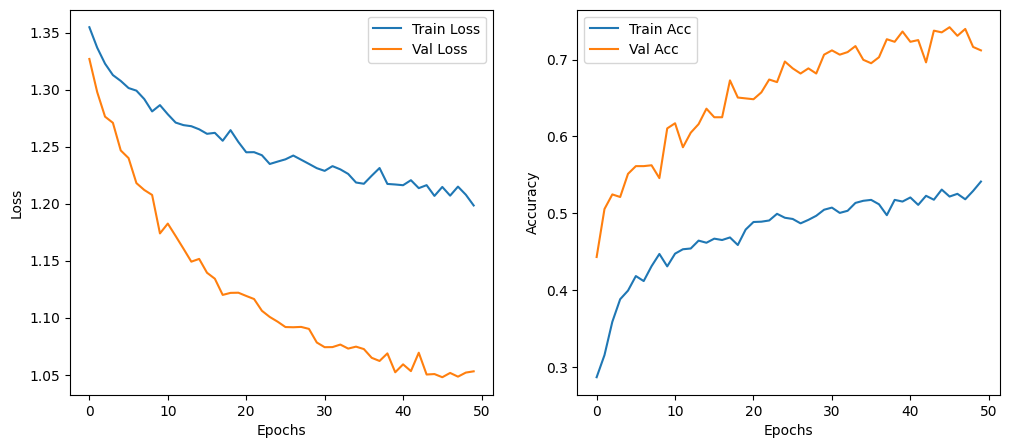

In [44]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Move the loss history to CPU and convert to NumPy arrays before plotting
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in train_loss_history]), label='Train Loss')
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in val_loss_history]), label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Move the accuracy history to CPU and convert to NumPy arrays before plotting
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in train_acc_history]), label='Train Acc')
plt.plot(np.array([t.cpu() if hasattr(t, 'cpu') else t for t in val_acc_history]), label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Classification report

In [46]:
# prompt: predict on the x_test dataset and create a classification using sklearn where Trure label are y_test

# Move the model to CPU
model.cpu()

X_test = torch.permute(X_test, (0, 3, 1, 2))
# Make predictions on the test set
y_pred = model(X_test.cpu())

# Convert the predictions to class labels
y_pred_classes = torch.argmax(y_pred, dim=1)

# Import necessary libraries


# Create a classification report
report = classification_report(y_test, y_pred_classes)

# Print the classification report
print(report)


              precision    recall  f1-score   support

         0.0       0.50      0.79      0.61       197
         1.0       0.67      0.37      0.47       271
         2.0       0.91      0.85      0.88       321
         3.0       0.73      0.81      0.77       265

    accuracy                           0.70      1054
   macro avg       0.70      0.70      0.68      1054
weighted avg       0.73      0.70      0.70      1054



Confusion matrix

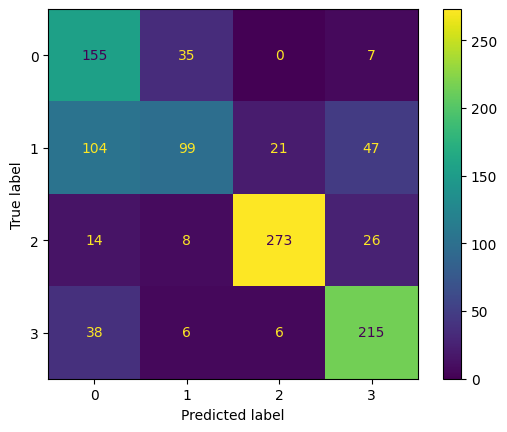

[[155  35   0   7]
 [104  99  21  47]
 [ 14   8 273  26]
 [ 38   6   6 215]]


In [49]:
prompt: create a confusion matrix using prediction from the model on the X_test and ture label y_test

from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = model(X_test.cpu())

# Convert the predictions to class labels
y_pred_classes = torch.argmax(y_pred, dim=1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# Print the confusion matrix
print(cm)
